In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn as nn
import os
import numpy as np
from matplotlib import pyplot as plot


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 1. Загрузка данных

In [2]:
# Загрузка набора данных CIFAR
data_transforms = transforms.Compose([
    transforms.Resize(244),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #приведения значений пикселей изображений к нормализованному диапазону
    ])
#https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
#https://robocraft.ru/computervision/4514

train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=data_transforms
)

test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=data_transforms
)

trainloader = torch.utils.data.DataLoader(train, batch_size=50,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=50, shuffle=False, num_workers=2)

# batch_size определяет количество образцов, которые будут переданы в модель для обработки в одной итерации обучения;
# shuffle перемешиванию данных во время обучения модели;


100%|██████████| 170498071/170498071 [00:03<00:00, 49238175.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(' Размер обучающей выборки', len(train), '\n', 'Размер тестовой выборки', len(test))

 Размер обучающей выборки 50000 
 Размер тестовой выборки 10000


* Визуализация датасета

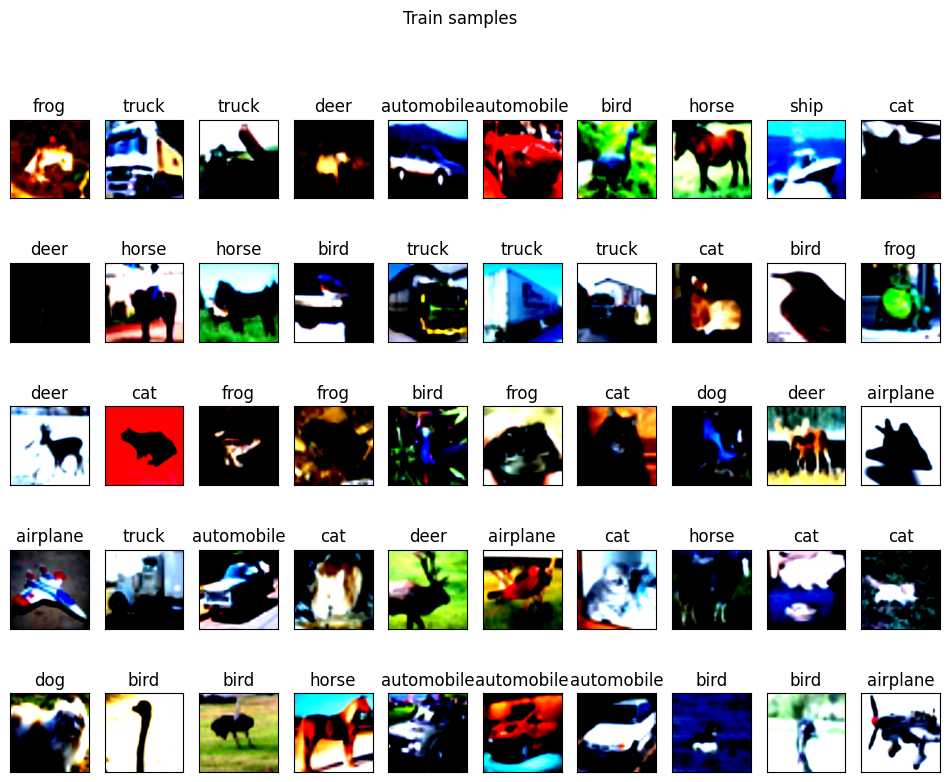

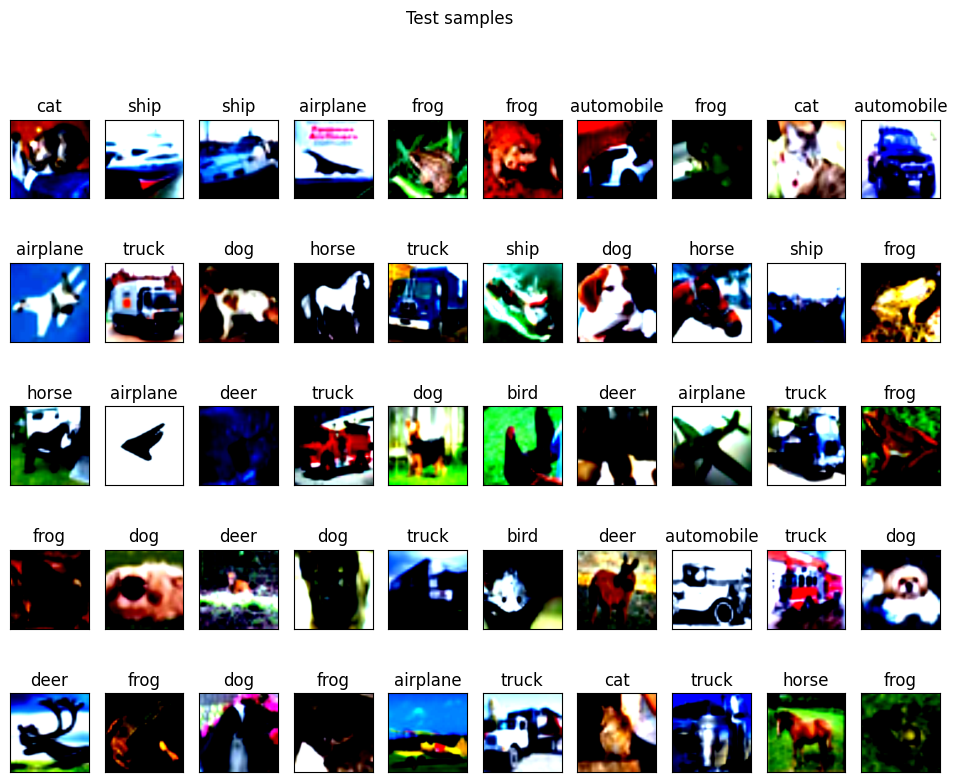

In [3]:
# Метки классов
classes={0: 'airplane', 1: 'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 5

    figsize = (12, 9)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0)
        ax.set_title(classes[images[i][1]])
        ax.imshow(img)
pass

show_images(train, 'Train samples')
show_images(test, 'Test samples')

In [ ]:
# Размер изображения:
test[0][0].shape

torch.Size([3, 244, 244])

In [4]:
def get_accuracy(data_loader, model):
    tp = 0 # число правильно предсказанных классов
    n = 0 # общее число обзразцов
    with torch.no_grad(): #для отключения вычисления градиентов
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входном батче
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # наибольшую вероятность предсказания (max) из outputs. Затем этот индекс сохраняется в переменную predicted
            n += labels.size(0)
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n




def training(trainloader, model, loss_fn, optimizer, num_epochs):
    train_accuracy = []  # список для хранения тренировочной точности
    test_accuracy = []  # список для хранения тестовой точности

    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(trainloader):
            images = images.requires_grad_().to(device)
            labels = labels.to(device)
            # переносит тензоры images и labels на устройство (например, GPU) и присваивает им требование градиента requires_grad_(), чтобы можно было вычислить градиенты для обновления весов модели

            # Прямой проход
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Обратный проход
            optimizer.zero_grad() # обнуление градиентов перед обратным проходом. При обратном проходе градиенты посчитываются для каждого веса, чтобы определить, как изменение весов влияет на значения функции потерь. 
            loss.backward() #  вычисление градиентов функции потерь по весам модели.
            optimizer.step() # обновление весов модели на основе вычисленных градиентов.

        # train accuracy по завершении эпохи
        train_acc = get_accuracy(trainloader, model)
        test_acc = get_accuracy(testloader, model)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        print('Epoch', epoch, 'train accuracy =', train_acc, 'test accuracy =', test_acc)

Загружаю модели предварительно обученные на данных ImageNet

- Архитектура AlexNet состоит из 5 сверточных слоев, 3 слоев объединения и 3 полносвязных слоев (использует сверточные фильтры разных размеров)
- Архитектура VGG16 состоит из 16 слоев свертки и полносвязных слоев. Модель VGG имеет более глубокую архитектуру по сравнению с AlexNet и более маленькими сверточными фильтрами 3x3
- Архитектура EfficientNet-v2_s основывается на принципе Compound Scaling и использовании блоков свертки с эффективной архитектурой. Архитектура EfficientNet-v2 состоит из нескольких идентичных сверточных блоков, которые повторяются несколько раз. В каждом сверточном блоке используется слоями Batch Normalization, ReLU и свертками с требуемыми параметрами. Архитектура также использует глубокие свертки, блоки с дропаутом и слои Global Average Pooling для усиления эффекта ансамбля моделей.
- Архитектура ResNet-18 состоит из 18 слоев, включая сверточные слои, блоки остатков и полносвязные слои. 

In [5]:
models = [torchvision.models.alexnet(pretrained=True), torchvision.models.vgg16(pretrained=True), torchvision.models.efficientnet_v2_s(pretrained=True), torchvision.models.resnet18(pretrained=True)]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 92.4MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remove

In [6]:
models_acc_0 = []
loss_fn = nn.CrossEntropyLoss()
learning_rate=0.001 # определяет величину шага, с которым алгоритм обновляет веса модели на каждой итерации обучения
num_epochs = [10, 2, 4, 4]

In [7]:
from tqdm import tqdm

# Модели с загруженными весами без заморозки

In [ ]:
for i, model in enumerate(models):
  model = model.cuda()
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)# Стохастический градиентный спуск. возвращает все обучаемые параметры модели, то есть веса (weights) и смещения (biases). Оптимизатор будет обновлять эти параметры в процессе обучения.

  training(trainloader, model, loss_fn, optimizer, num_epochs[i])
  models_acc_0.append(get_accuracy(testloader, model))
  print(models)
# momentum=0.9: это параметр импульса, который помогает устранить проблему локального минимума. Он определяет, какая часть предыдущего изменения параметров будет добавлена к текущему изменению. Значение 0.9 означает, что 90% предыдущего изменения будет добавлено к текущему изменению параметров.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

 10%|█         | 1/10 [04:22<39:21, 262.40s/it]

Epoch 0 train accuracy = tensor(0.8003, device='cuda:0') test accuracy = tensor(0.7861, device='cuda:0')


 20%|██        | 2/10 [08:39<34:34, 259.27s/it]

Epoch 1 train accuracy = tensor(0.8608, device='cuda:0') test accuracy = tensor(0.8382, device='cuda:0')


 30%|███       | 3/10 [12:52<29:55, 256.50s/it]

Epoch 2 train accuracy = tensor(0.8940, device='cuda:0') test accuracy = tensor(0.8609, device='cuda:0')


 40%|████      | 4/10 [17:02<25:24, 254.04s/it]

Epoch 3 train accuracy = tensor(0.9032, device='cuda:0') test accuracy = tensor(0.8606, device='cuda:0')


 50%|█████     | 5/10 [21:22<21:19, 255.94s/it]

Epoch 4 train accuracy = tensor(0.9295, device='cuda:0') test accuracy = tensor(0.8775, device='cuda:0')


 60%|██████    | 6/10 [25:35<16:59, 254.95s/it]

Epoch 5 train accuracy = tensor(0.9334, device='cuda:0') test accuracy = tensor(0.8736, device='cuda:0')


 70%|███████   | 7/10 [29:51<12:45, 255.20s/it]

Epoch 6 train accuracy = tensor(0.9484, device='cuda:0') test accuracy = tensor(0.8869, device='cuda:0')


 80%|████████  | 8/10 [34:02<08:28, 254.02s/it]

Epoch 7 train accuracy = tensor(0.9531, device='cuda:0') test accuracy = tensor(0.8884, device='cuda:0')


 90%|█████████ | 9/10 [38:15<04:13, 253.70s/it]

Epoch 8 train accuracy = tensor(0.9573, device='cuda:0') test accuracy = tensor(0.8822, device='cuda:0')


100%|██████████| 10/10 [42:27<00:00, 254.78s/it]

Epoch 9 train accuracy = tensor(0.9693, device='cuda:0') test accuracy = tensor(0.8930, device='cuda:0')


[AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 50%|█████     | 1/2 [24:29<24:29, 1469.04s/it]

tensor(0.8642, device='cuda:0') test accuracy = tensor(0.8424, device='cuda:0')
Epoch 1 train accuracy = 

100%|██████████| 2/2 [48:57<00:00, 1468.91s/it]

tensor(0.8985, device='cuda:0') test accuracy = tensor(0.8611, device='cuda:0')


[AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


 25%|██▌       | 1/4 [16:36<49:48, 996.21s/it]

Epoch 0 train accuracy = tensor(0.9472, device='cuda:0') test accuracy = tensor(0.9331, device='cuda:0')


 50%|█████     | 2/4 [33:12<33:12, 996.02s/it]

Epoch 1 train accuracy = tensor(0.9724, device='cuda:0') test accuracy = tensor(0.9523, device='cuda:0')


 75%|███████▌  | 3/4 [49:50<16:36, 996.91s/it]

Epoch 2 train accuracy = tensor(0.9826, device='cuda:0') test accuracy = tensor(0.9598, device='cuda:0')


100%|██████████| 4/4 [1:06:26<00:00, 996.64s/it]

Epoch 3 train accuracy = tensor(0.9886, device='cuda:0') test accuracy = tensor(0.9607, device='cuda:0')


[AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


  0%|          | 0/5 [02:50<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
models_acc_0

[tensor(0.8946, device='cuda:0'),
 tensor(0.8626, device='cuda:0'),
 tensor(0.9617, device='cuda:0')]

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 
training(trainloader, model, loss_fn, optimizer, 4)

print('Test accuracy: {}'.format(get_accuracy(testloader, model)))
models_acc_0.append(get_accuracy(testloader, model))
models_acc_0

 25%|██▌       | 1/4 [06:05<18:17, 365.68s/it]

Epoch 0 train accuracy = tensor(0.9383, device='cuda:0') test accuracy = tensor(0.9074, device='cuda:0')


 50%|█████     | 2/4 [12:15<12:16, 368.40s/it]

Epoch 1 train accuracy = tensor(0.9725, device='cuda:0') test accuracy = tensor(0.9250, device='cuda:0')


 75%|███████▌  | 3/4 [18:19<06:06, 366.13s/it]

Epoch 2 train accuracy = tensor(0.9883, device='cuda:0') test accuracy = tensor(0.9289, device='cuda:0')


100%|██████████| 4/4 [24:21<00:00, 365.45s/it]

Epoch 3 train accuracy = tensor(0.9946, device='cuda:0') test accuracy = tensor(0.9321, device='cuda:0')


Test accuracy: 0.9320999979972839


[tensor(0.8946, device='cuda:0'),
 tensor(0.8626, device='cuda:0'),
 tensor(0.9617, device='cuda:0'),
 tensor(0.9321, device='cuda:0')]

In [ ]:
print("Результаты первого эксперимента:")
model_names = ["alexnet", "vgg16", "EfficientNet", "resnet18"]
for i, model_name in enumerate(model_names):
    print(f"{model_name} experiment №1: Accuracy = {models_acc_0[i]}")

Результаты первого эксперимента:
alexnet experiment №1: Accuracy = 0.894599974155426
vgg16 experiment №1: Accuracy = 0.8625999689102173
EfficientNet experiment №1: Accuracy = 0.9616999626159668
resnet18 experiment №1: Accuracy = 0.9320999979972839


# Меняю классификатор модели на новый слой nn.Linear

In [ ]:
torch.cuda.empty_cache()
models = [torchvision.models.alexnet(pretrained=True), torchvision.models.vgg16(pretrained=True), torchvision.models.efficientnet_v2_s(pretrained=True), torchvision.models.resnet18(pretrained=True)]
model_names = ["alexnet", "vgg16", "EfficientNet", "resnet18"]

models_acc_1 = []
loss_fn = nn.CrossEntropyLoss()
num_epochs = [10, 2, 4, 5]
num_classes = 10

for i, model in enumerate(models):
  print(model_names[i])
  if model_names[i] == "alexnet":
      model.classifier = nn.Linear(model.classifier[1].in_features, num_classes)
  elif model_names[i] == "vgg16":
      model.classifier = nn.Linear(model.classifier[0].in_features, num_classes)
  elif model_names[i] == "EfficientNet":
    model.classifier = nn.Linear(model.classifier[1].in_features, num_classes)
  else:
    model.fc = nn.Linear(model.fc.in_features, num_classes)
  model = model.cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  training(trainloader, model, loss_fn, optimizer, num_epochs[i])
  models_acc_1.append(get_accuracy(testloader, model))

alexnet


 10%|█         | 1/10 [04:09<37:22, 249.13s/it]

Epoch 0 train accuracy = tensor(0.8835, device='cuda:0') test accuracy = tensor(0.8464, device='cuda:0')


 20%|██        | 2/10 [08:10<32:35, 244.48s/it]

Epoch 1 train accuracy = tensor(0.9280, device='cuda:0') test accuracy = tensor(0.8698, device='cuda:0')


 30%|███       | 3/10 [12:13<28:28, 244.00s/it]

Epoch 2 train accuracy = tensor(0.9524, device='cuda:0') test accuracy = tensor(0.8719, device='cuda:0')


 40%|████      | 4/10 [16:18<24:25, 244.17s/it]

Epoch 3 train accuracy = tensor(0.9626, device='cuda:0') test accuracy = tensor(0.8758, device='cuda:0')


 50%|█████     | 5/10 [20:20<20:17, 243.46s/it]

Epoch 4 train accuracy = tensor(0.9769, device='cuda:0') test accuracy = tensor(0.8758, device='cuda:0')


 60%|██████    | 6/10 [24:23<16:13, 243.31s/it]

Epoch 5 train accuracy = tensor(0.9799, device='cuda:0') test accuracy = tensor(0.8736, device='cuda:0')


 70%|███████   | 7/10 [28:26<12:09, 243.21s/it]

Epoch 6 train accuracy = tensor(0.9927, device='cuda:0') test accuracy = tensor(0.8841, device='cuda:0')


 80%|████████  | 8/10 [32:29<08:06, 243.08s/it]

Epoch 7 train accuracy = tensor(0.9972, device='cuda:0') test accuracy = tensor(0.8836, device='cuda:0')


 90%|█████████ | 9/10 [36:31<04:02, 242.86s/it]

Epoch 8 train accuracy = tensor(0.9989, device='cuda:0') test accuracy = tensor(0.8854, device='cuda:0')


100%|██████████| 10/10 [40:32<00:00, 243.28s/it]

Epoch 9 train accuracy = tensor(1., device='cuda:0') test accuracy = tensor(0.8944, device='cuda:0')


vgg16


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 50%|█████     | 1/2 [21:43<21:43, 1303.64s/it]

tensor(0.9506, device='cuda:0') test accuracy = tensor(0.9006, device='cuda:0')


100%|██████████| 2/2 [43:26<00:00, 1303.42s/it]

Epoch 1 train accuracy = tensor(0.9807, device='cuda:0') test accuracy = tensor(0.9124, device='cuda:0')


EfficientNet


 25%|██▌       | 1/4 [15:21<46:05, 921.77s/it]

Epoch 0 train accuracy = tensor(0.9592, device='cuda:0') test accuracy = tensor(0.9451, device='cuda:0')


 50%|█████     | 2/4 [30:42<30:42, 921.44s/it]

Epoch 1 train accuracy = tensor(0.9771, device='cuda:0') test accuracy = tensor(0.9558, device='cuda:0')


 75%|███████▌  | 3/4 [46:04<15:21, 921.33s/it]

Epoch 2 train accuracy = tensor(0.9851, device='cuda:0') test accuracy = tensor(0.9617, device='cuda:0')


100%|██████████| 4/4 [1:01:25<00:00, 921.34s/it]

Epoch 3 train accuracy = tensor(0.9897, device='cuda:0') test accuracy = tensor(0.9630, device='cuda:0')


resnet18


 20%|██        | 1/5 [05:42<22:51, 342.78s/it]

Epoch 0 train accuracy = tensor(0.9407, device='cuda:0') test accuracy = tensor(0.9176, device='cuda:0')


 40%|████      | 2/5 [11:23<17:05, 341.69s/it]

Epoch 1 train accuracy = tensor(0.9674, device='cuda:0') test accuracy = tensor(0.9296, device='cuda:0')


 60%|██████    | 3/5 [17:05<11:23, 341.83s/it]

Epoch 2 train accuracy = tensor(0.9837, device='cuda:0') test accuracy = tensor(0.9369, device='cuda:0')


 80%|████████  | 4/5 [22:48<05:42, 342.37s/it]

Epoch 3 train accuracy = tensor(0.9918, device='cuda:0') test accuracy = tensor(0.9390, device='cuda:0')


100%|██████████| 5/5 [28:33<00:00, 342.64s/it]

Epoch 4 train accuracy = tensor(0.9965, device='cuda:0') test accuracy = tensor(0.9409, device='cuda:0')


In [ ]:
print("Результаты второго эксперимента:")
model_names = ["alexnet", "vgg16", "EfficientNet", "resnet18"]
for i, model_name in enumerate(model_names):
    print(f"{model_name} experiment №1: Accuracy = {models_acc_1[i]}")

Результаты второго эксперимента:
alexnet experiment №1: Accuracy = 0.8944000005722046
vgg16 experiment №1: Accuracy = 0.91239994764328
EfficientNet experiment №1: Accuracy = 0.9641000032424927
resnet18 experiment №1: Accuracy = 0.9408999681472778


# Замараживаю веса модели и меняю классификатор модели на новый слой nn.Linear и

In [8]:
torch.cuda.empty_cache()
models = [torchvision.models.alexnet(pretrained=True), torchvision.models.vgg16(pretrained=True), torchvision.models.efficientnet_v2_s(pretrained=True), torchvision.models.resnet18(pretrained=True)]
model_names = ["alexnet", "vgg16", "EfficientNet", "resnet18"]

models_acc_2 = []
loss_fn = nn.CrossEntropyLoss()
num_epochs = [10, 2, 4, 5]
num_classes = 10

for i, model in enumerate(models):
  print(model_names[i])
  for param in model.parameters():
    param.requires_grad = False # во время обучения эти параметры не будут автоматически обновляться (градиенты не будут вычисляться для них).

  if model_names[i] == "alexnet":
      model.classifier = nn.Linear(model.classifier[1].in_features, num_classes)
  elif model_names[i] == "vgg16":
      model.classifier = nn.Linear(model.classifier[0].in_features, num_classes)
  elif model_names[i] == "EfficientNet":
    model.classifier = nn.Linear(model.classifier[1].in_features, num_classes)
  else:
    model.fc = nn.Linear(model.fc.in_features, num_classes)
  print("Параметры алгоритма обучения:")
  for param in model.parameters():
      print(param.requires_grad)
  model = model.cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  training(trainloader, model, loss_fn, optimizer, num_epochs[i])
  models_acc_2.append(get_accuracy(testloader, model))




alexnet
Параметры алгоритма обучения:
False
False
False
False
False
False
False
False
False
False
True
True


 10%|█         | 1/10 [04:03<36:30, 243.42s/it]

Epoch 0 train accuracy = tensor(0.8621, device='cuda:0') test accuracy = tensor(0.8228, device='cuda:0')


 20%|██        | 2/10 [07:57<31:44, 238.01s/it]

Epoch 1 train accuracy = tensor(0.8736, device='cuda:0') test accuracy = tensor(0.8229, device='cuda:0')


 30%|███       | 3/10 [11:47<27:19, 234.18s/it]

Epoch 2 train accuracy = tensor(0.8884, device='cuda:0') test accuracy = tensor(0.8282, device='cuda:0')


 40%|████      | 4/10 [15:40<23:22, 233.81s/it]

Epoch 3 train accuracy = tensor(0.9087, device='cuda:0') test accuracy = tensor(0.8335, device='cuda:0')


 50%|█████     | 5/10 [19:35<19:31, 234.23s/it]

Epoch 4 train accuracy = tensor(0.9105, device='cuda:0') test accuracy = tensor(0.8264, device='cuda:0')


 60%|██████    | 6/10 [23:29<15:37, 234.26s/it]

Epoch 5 train accuracy = tensor(0.9263, device='cuda:0') test accuracy = tensor(0.8347, device='cuda:0')


 70%|███████   | 7/10 [27:24<11:43, 234.51s/it]

Epoch 6 train accuracy = tensor(0.9282, device='cuda:0') test accuracy = tensor(0.8333, device='cuda:0')


 80%|████████  | 8/10 [31:18<07:48, 234.31s/it]

Epoch 7 train accuracy = tensor(0.9384, device='cuda:0') test accuracy = tensor(0.8335, device='cuda:0')


 90%|█████████ | 9/10 [35:14<03:54, 234.64s/it]

Epoch 8 train accuracy = tensor(0.9484, device='cuda:0') test accuracy = tensor(0.8378, device='cuda:0')


100%|██████████| 10/10 [38:56<00:00, 233.69s/it]

Epoch 9 train accuracy = tensor(0.9449, device='cuda:0') test accuracy = tensor(0.8329, device='cuda:0')


vgg16
Параметры алгоритма обучения:
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 train accuracy = 

 50%|█████     | 1/2 [19:01<19:01, 1141.52s/it]

tensor(0.9120, device='cuda:0') test accuracy = tensor(0.8595, device='cuda:0')
Epoch 1 train accuracy = 

100%|██████████| 2/2 [38:01<00:00, 1140.95s/it]

tensor(0.9512, device='cuda:0') test accuracy = tensor(0.8701, device='cuda:0')


EfficientNet
Параметры алгоритма обучения:
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

 25%|██▌       | 1/4 [13:11<39:33, 791.05s/it]

Epoch 0 train accuracy = tensor(0.7110, device='cuda:0') test accuracy = tensor(0.7099, device='cuda:0')


 50%|█████     | 2/4 [26:21<26:21, 790.99s/it]

Epoch 1 train accuracy = tensor(0.7289, device='cuda:0') test accuracy = tensor(0.7222, device='cuda:0')


 75%|███████▌  | 3/4 [39:33<13:11, 791.23s/it]

Epoch 2 train accuracy = tensor(0.7376, device='cuda:0') test accuracy = tensor(0.7303, device='cuda:0')


100%|██████████| 4/4 [52:46<00:00, 791.57s/it]

Epoch 3 train accuracy = tensor(0.7433, device='cuda:0') test accuracy = tensor(0.7393, device='cuda:0')


resnet18
Параметры алгоритма обучения:
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


 20%|██        | 1/5 [04:57<19:49, 297.45s/it]

Epoch 0 train accuracy = tensor(0.7544, device='cuda:0') test accuracy = tensor(0.7500, device='cuda:0')


 40%|████      | 2/5 [09:53<14:50, 296.74s/it]

Epoch 1 train accuracy = tensor(0.7727, device='cuda:0') test accuracy = tensor(0.7707, device='cuda:0')


 60%|██████    | 3/5 [14:49<09:52, 296.39s/it]

Epoch 2 train accuracy = tensor(0.7799, device='cuda:0') test accuracy = tensor(0.7788, device='cuda:0')


 80%|████████  | 4/5 [19:47<04:56, 296.89s/it]

Epoch 3 train accuracy = tensor(0.7845, device='cuda:0') test accuracy = tensor(0.7837, device='cuda:0')


100%|██████████| 5/5 [24:44<00:00, 296.97s/it]

Epoch 4 train accuracy = tensor(0.7854, device='cuda:0') test accuracy = tensor(0.7841, device='cuda:0')


In [9]:
print("Результаты второго эксперимента:")
model_names = ["alexnet", "vgg16", "EfficientNet", "resnet18"]
for i, model_name in enumerate(model_names):
    print(f"{model_name} experiment №1: Accuracy = {models_acc_2[i]}")

Результаты второго эксперимента:
alexnet experiment №1: Accuracy = 0.8328999876976013
vgg16 experiment №1: Accuracy = 0.8700999617576599
EfficientNet experiment №1: Accuracy = 0.7372999787330627
resnet18 experiment №1: Accuracy = 0.7840999960899353


Визуализация результатов

In [31]:
models_acc_2 = [0.8328999876976013, 0.8700999617576599, 0.7372999787330627, 0.7840999960899353]
models_acc_1 = [0.8944000005722046, 0.91239994764328, 0.9641000032424927, 0.9408999681472778]
models_acc_0 = [0.894599974155426, 0.8625999689102173, 0.9616999626159668, 0.9320999979972839]
pract_1 = [0.7721999883651733]

<ipython-input-51-283fb896bc6d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups = np.array(results)


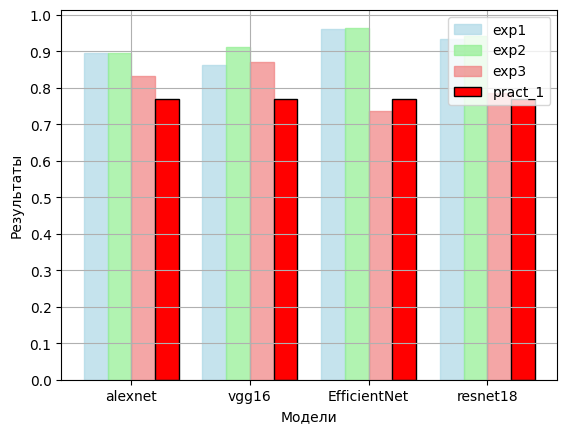

In [51]:
import matplotlib.pyplot as plt
import numpy as np

results = [models_acc_0, models_acc_1, models_acc_2, pract_1]
groups = np.array(results)
labels = ["alexnet", "vgg16", "EfficientNet", "resnet18"]# Подписи для моделей
experiments = ["exp1", "exp2", "exp3", 'pract_1']

# Создание гистограммы
fig, ax = plt.subplots()
index = np.arange(len(labels))
bar_width = 0.2
alpha = [0.7, 0.7, 0.7, 1]

colors = ['lightblue', 'lightgreen', 'lightcoral', 'red']
edgecolor = ['lightblue', 'lightgreen', 'lightcoral', 'black']

# Построение гистограммы для каждой группы
for i, group in enumerate(groups):
    plt.bar(index + i * bar_width, group, bar_width, label=experiments[i], color=colors[i], alpha=alpha[i], edgecolor=edgecolor[i])

# Настройка осей и легенды
ax.set_xlabel("Модели")
ax.set_ylabel("Результаты")
ax.set_xticks(index + (len(groups) - 1) * bar_width / 2)
ax.set_xticklabels(labels)
ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.grid(True)
ax.legend()

# Показать гистограмму
plt.show()


Лучший результат оказался у модели EfficientNet для 1 и 2 эксперимента = 0.961 и 0.964 (t1= 01:06:26, t2= 01:01:25) еще хорошие результаты у модели resnet18 во втором эксперименте 0.9404 (t1= 28:33)

# Меняю гиперпараметры и количесвто эпох для некоторых моделей

In [ ]:
models = [torchvision.models.alexnet(pretrained=True), torchvision.models.vgg16(pretrained=True), torchvision.models.efficientnet_v2_s(pretrained=True), torchvision.models.resnet18(pretrained=True)]

models_acc_3 = []
loss_fn = nn.CrossEntropyLoss()
num_epochs = [10, 3, 4, 5]

for i, model in enumerate(models):
  model = model.cuda()
  print("Метод инициализации весов сети:")
  print(model._get_name())
  print("Параметры алгоритма обучения:")
  for name, param in model.named_parameters():
      if param.requires_grad:
          print(name)

  print(count_trainable_parameters(model))
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  training(trainloader, model, loss_fn, optimizer, num_epochs[i])
  models_acc_3.append(get_accuracy(testloader, model))
  print(models)